# In this file I am plotting the thickness over the cardiac cycle for the 4 different pathologies

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
from scipy.interpolate import interp1d

In [28]:
def plot_thickness_map_sep_color_bars(mean_map, mean_bool=True, save_path = None):
    # Create figure with appropriate size and spacing (matching your reference style)
    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

    # Define the exact same modern color palette for consistency
    colors = {
        'no_top': '#4B6FA5',      # Modern blue
        'all_slices': '#C10E21',  # JAHA red
        'offset': "#2E8B57",      # matching green that also colorblind people can differentiate
        'ground_truth': "#000000", # black
        'volume_mesh': "#868686"   # grey
    }

    # Use your custom colormap colors but maintain consistency with your style
    heatmap_colors = [colors['no_top'], '#D3D3D3', colors['all_slices']]  # Blue, Light Grey, Red
    cmap = LinearSegmentedColormap.from_list('custom', heatmap_colors, N=256)
    cmap.set_bad(color=colors['ground_truth'], alpha=0.8)  # Use your black color

    # Create the heatmap
    im = ax.imshow(mean_map, aspect='auto', cmap=cmap)

    # Beautiful labels and title with better sizing (matching your reference style exactly)
    ax.set_xlabel("Normalized Time Step in Cardiac Cycle", fontsize=16, fontweight='bold', color='#000000')
    ax.set_ylabel("Azimuthal Angle", fontsize=16, fontweight='bold', color='#000000')

    if mean_bool:
        ax.set_title("Mean Radial Thickness Map", fontsize=18, fontweight='bold', color='#000000', pad=15)
    else:
        ax.set_title("Std of Radial Thickness Map", fontsize=18, fontweight='bold', color='#000000', pad=15)

    # Improve tick styling (matching your reference)
    ax.tick_params(axis='both', which='major', labelsize=11, colors='#000000')

    n_theta_bins = 36
    tick_angles = np.linspace(0, 360, n_theta_bins + 1)  # 0 to 360 in 10° steps
    tick_locs = np.linspace(-0.5, n_theta_bins - 0.5, n_theta_bins + 1)

    # Only keep angles that are divisible by 30°
    filtered_ticks = [(loc, angle) for loc, angle in zip(tick_locs, tick_angles) if angle % 30 == 0]
    filtered_locs, filtered_labels = zip(*filtered_ticks)

    plt.yticks(filtered_locs, [f"{int(angle)}°" for angle in filtered_labels], fontsize=11)


    # Clean up spines (matching your reference style)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#000000')
    ax.spines['bottom'].set_color('#000000')
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)

    # Invert y-axis as in original
    ax.invert_yaxis()

    # Add clean white background (matching your reference)
    ax.set_facecolor('#FFFFFF')

    # Create colorbar with matching styling
    cbar = plt.colorbar(im, ax=ax, label="Radial Thickness (mm)", shrink=0.8)
    cbar.ax.tick_params(labelsize=11, colors='#000000')
    cbar.set_label("Radial Thickness (mm)", fontsize=16, fontweight='bold', color='#000000')

    # Style the colorbar outline to match
    cbar.outline.set_edgecolor('#000000')
    cbar.outline.set_linewidth(1.2)

    # Use subplots_adjust for better control over spacing (exactly like your reference)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

    if save_path:
        plt.savefig(save_path,dpi = 300)

    plt.show()

In [2]:
def plot_thickness_map(mean_map, std_map, save_path_mean = None, save_path_std = None):
    def create_colormap():
        colors = {
            'no_top': '#4B6FA5',      # Modern blue
            'all_slices': '#C10E21',  # JAHA red
            'offset': "#2E8B57",      # Colorblind-friendly green
            'ground_truth': "#000000", # Black
            'volume_mesh': "#868686"   # Grey
        }

        heatmap_colors = [colors['no_top'], '#D3D3D3', colors['all_slices']]
        cmap = LinearSegmentedColormap.from_list('custom', heatmap_colors, N=256)
        cmap.set_bad(color=colors['ground_truth'], alpha=0.8)
        return cmap

    def plot_single_map(data, title, cmap, norm, save_path):
        fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
        im = ax.imshow(data, aspect='auto', cmap=cmap, norm=norm, extent=[0, 1, 1, 0])

        # Labels and title
        ax.set_title(title, fontsize=18, fontweight='bold', color='#000000', pad=15)
        ax.set_xlabel("Normalized Time Step in Cardiac Cycle", fontsize=16, fontweight='bold', color='#000000')
        ax.set_ylabel("Normalized Z Height", fontsize=16, fontweight='bold', color='#000000')

        # Ticks
        ax.tick_params(axis='both', which='major', labelsize=11, colors='#000000')

        # Spines
        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color('#000000')
            ax.spines[spine].set_linewidth(1.2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Styling
        ax.invert_yaxis()
        ax.set_facecolor('#FFFFFF')

        # Colorbar
        cbar = plt.colorbar(im, ax=ax, label="Radial Thickness (mm)", shrink=0.8)
        cbar.ax.tick_params(labelsize=11, colors='#000000')
        cbar.set_label("Radial Thickness (mm)", fontsize=16, fontweight='bold', color='#000000')
        cbar.outline.set_edgecolor('#000000')
        cbar.outline.set_linewidth(1.2)

        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9)

        if save_path:
            plt.savefig(save_path, dpi = 300)

        plt.show()

    # Shared colormap and normalization
    cmap = create_colormap()
    global_min = min(mean_map.min(), std_map.min())
    global_max = max(mean_map.max(), std_map.max())
    norm = Normalize(vmin=global_min, vmax=global_max)

    # Plot both maps
    plot_single_map(mean_map, "Mean Radial Thickness Map", cmap, norm, save_path_mean)
    plot_single_map(std_map, "Standard Deviation of Thickness Map", cmap, norm, save_path_std)

In [3]:
#Lists of the names of the data sets of the 4 different pathologies
datasets_healthy = ['SCD0003701','SCD0003801','SCD0003901','SCD0004001','SCD0004101','SCD0004201','SCD0004301','SCD0004401','SCD0004501']
datasets_failure_infarct = ['SCD0000101','SCD0000201','SCD0000301','SCD0000401','SCD0000501','SCD0000601', 'SCD0000701','SCD0000801','SCD0000901','SCD0001001','SCD0001101','SCD0001201']
datasets_failure = ['SCD0001301','SCD0001401','SCD0001501','SCD0001601','SCD0001701','SCD0001801','SCD0001901','SCD0002001','SCD0002101','SCD0002201','SCD0002301','SCD0002401']
datasets_Lv = ['SCD0002501','SCD0002601','SCD0002701','SCD0002801','SCD0002901','SCD0003001','SCD0003101','SCD0003201','SCD0003301','SCD0003401','SCD0003501','SCD0003601']

# Healthy Data Sets

## Calculate thickness map averaged over cardiac cycle for data sets individually

In [13]:
#write code to generate the numpy array for all time steps for one data set
all_thickness_maps = {}


for dataset in datasets_healthy:
    thickness_maps_o_time = []
    i = 0

    while True:
        try:
            z_coords = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/filtered_z_coords_{i}.npy")
            thickness_map = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/thickness_map_{i}.npy")  # fixed typo: used f-string correctly

            # Average over time to get 1D vector
            z_thickness_map = np.nanmean(thickness_map, axis=0).reshape(-1, 1)
            thickness_maps_o_time.append(z_thickness_map)

            i += 1  # continue to next index

        except FileNotFoundError:
            break  # stop loop when no more files are found

    # Convert to array (shape: num_subjects × z × 1)
    thickness_maps_o_time = np.concatenate(thickness_maps_o_time, axis=1)  # now shape (z, N)

    # In your loop over datasets
    all_thickness_maps[dataset] = thickness_maps_o_time


## Average thickness maps for all healthy datasets

In [14]:
#interpolate so that all thickness maps have the same time points along the time axis

# Define target time grid
target_time_len = 20
target_time = np.linspace(0, 1, target_time_len)

interpolated_maps = []

for dataset in datasets_healthy:
    thickness_map = all_thickness_maps[dataset]
    original_time_len = thickness_map.shape[1]
    original_time = np.linspace(0, 1, original_time_len)

    interpolated_map = np.empty((thickness_map.shape[0], target_time_len))

    for z_idx in range(thickness_map.shape[0]):
        row = thickness_map[z_idx, :]

        if np.all(np.isnan(row)):
            interpolated_map[z_idx, :] = np.nan
            continue

        valid_mask = ~np.isnan(row)
        interp = interp1d(original_time[valid_mask], row[valid_mask],
                          kind='linear', bounds_error=False, fill_value=np.nan)
        interpolated_map[z_idx, :] = interp(target_time)

    interpolated_maps.append(interpolated_map)

# Stack: shape (20, 20, N)
stacked = np.stack(interpolated_maps, axis=2)

# Compute average and std over the 3rd axis (samples)
mean_map = np.nanmean(stacked, axis=2)
std_map = np.nanstd(stacked, axis=2)

## Same Colorbar for Mean and Std

## Different Colorbar for Mean and Std

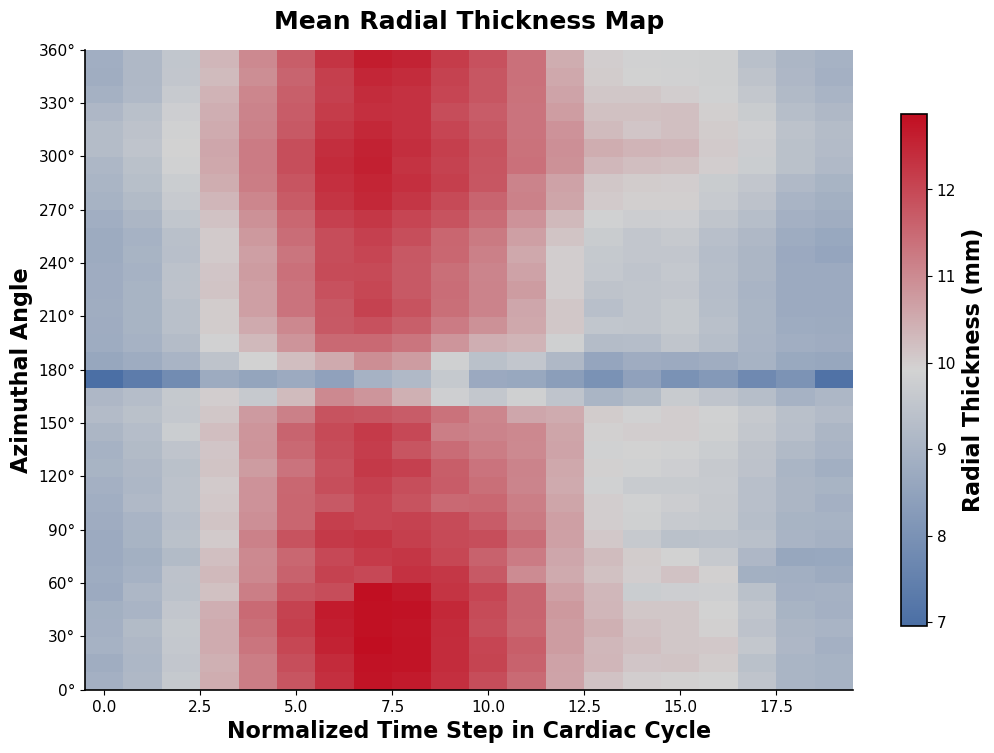

In [29]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Healthy_mean_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(mean_map, mean_bool=True, save_path = save_path)

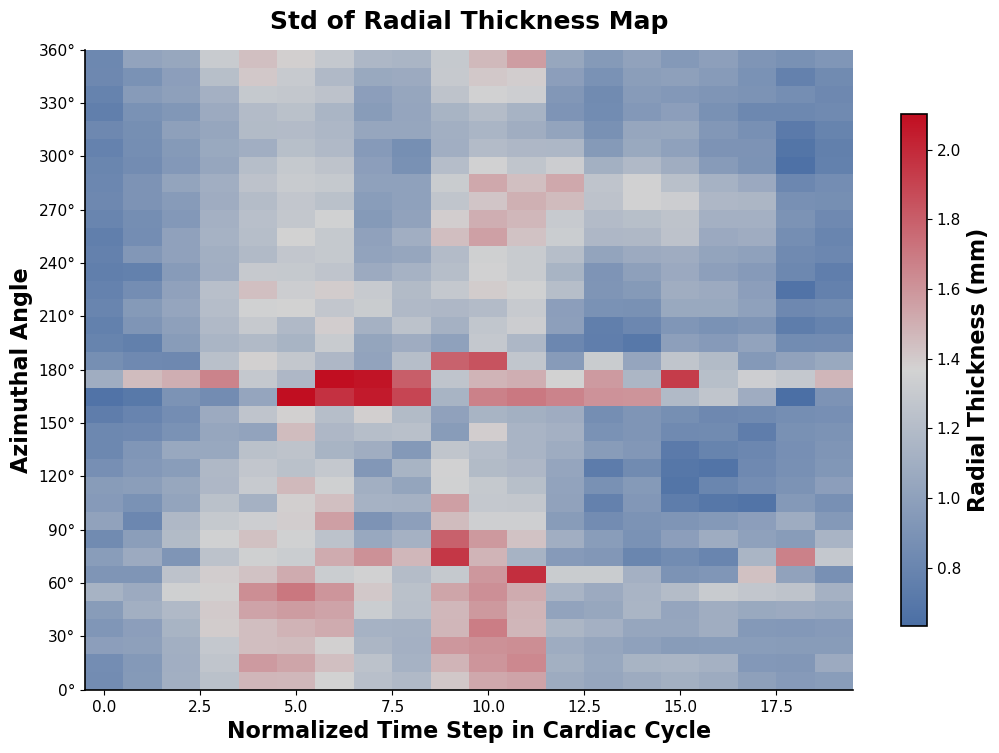

In [30]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Healthy_std_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(std_map, mean_bool=False, save_path=save_path)

# Heart Failure with Infarct

In [38]:
#write code to generate the numpy array for all time steps for one data set
all_thickness_maps = {}


for dataset in datasets_failure_infarct:
    thickness_maps_o_time = []
    i = 0

    while True:
        try:
            z_coords = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/filtered_z_coords_{i}.npy")
            thickness_map = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/thickness_map_{i}.npy")  # fixed typo: used f-string correctly

            # Average over time to get 1D vector
            z_thickness_map = np.nanmean(thickness_map, axis=0).reshape(-1, 1)
            thickness_maps_o_time.append(z_thickness_map)

            i += 1  # continue to next index

        except FileNotFoundError:
            break  # stop loop when no more files are found
    try:
        # Convert to array (shape: num_subjects × z × 1)
        thickness_maps_o_time = np.concatenate(thickness_maps_o_time, axis=1)  # now shape (z, N)
        # In your loop over datasets
        all_thickness_maps[dataset] = thickness_maps_o_time
    except Exception as e:
            print(f"Error in Dataset {dataset}: {e}")



Error in Dataset SCD0000601: need at least one array to concatenate
Error in Dataset SCD0000801: need at least one array to concatenate


In [39]:
#interpolate so that all thickness maps have the same time points along the time axis

# Define target time grid
target_time_len = 20
target_time = np.linspace(0, 1, target_time_len)

interpolated_maps = []

for dataset in datasets_failure_infarct:
    try:
        thickness_map = all_thickness_maps[dataset]
        original_time_len = thickness_map.shape[1]
        original_time = np.linspace(0, 1, original_time_len)

        interpolated_map = np.empty((thickness_map.shape[0], target_time_len))

        for z_idx in range(thickness_map.shape[0]):
            row = thickness_map[z_idx, :]

            if np.all(np.isnan(row)):
                interpolated_map[z_idx, :] = np.nan
                continue

            valid_mask = ~np.isnan(row)
            interp = interp1d(original_time[valid_mask], row[valid_mask],
                            kind='linear', bounds_error=False, fill_value=np.nan)
            interpolated_map[z_idx, :] = interp(target_time)

        interpolated_maps.append(interpolated_map)

    except Exception as e:
            print(f"Error in Dataset {dataset}: {e}")


# Stack: shape (20, 20, N)
stacked = np.stack(interpolated_maps, axis=2)

# Compute average and std over the 3rd axis (samples)
mean_map = np.nanmean(stacked, axis=2)
std_map = np.nanstd(stacked, axis=2)

Error in Dataset SCD0000601: 'SCD0000601'
Error in Dataset SCD0000801: 'SCD0000801'


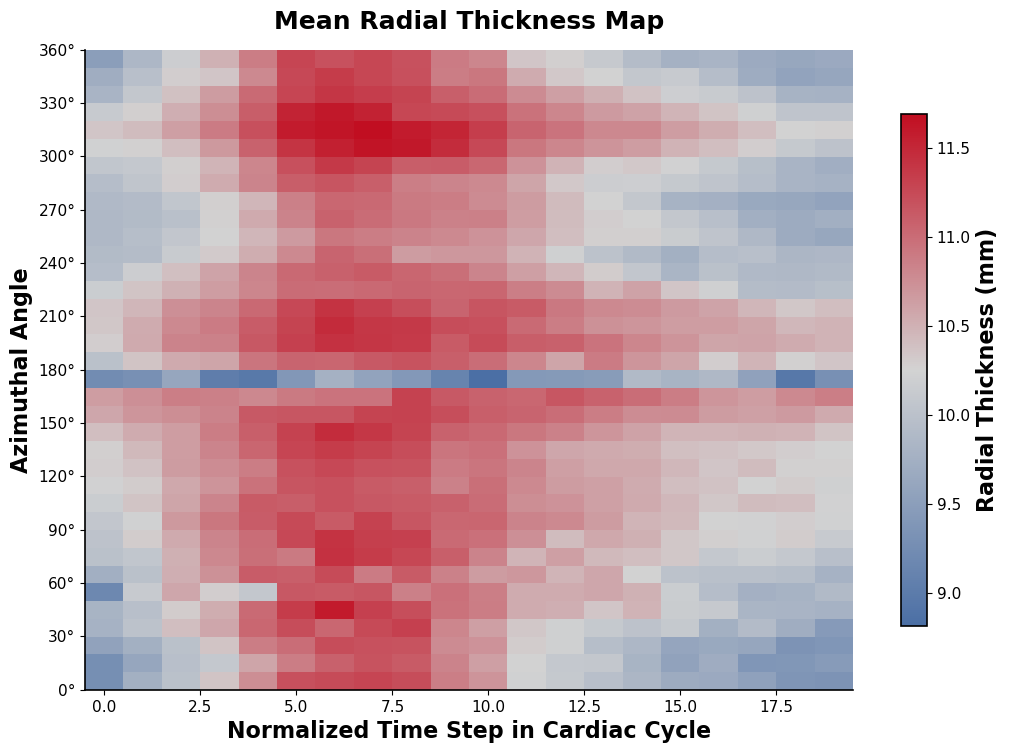

In [40]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Heart_Failure_Infarct_mean_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(mean_map, mean_bool=True, save_path = save_path)

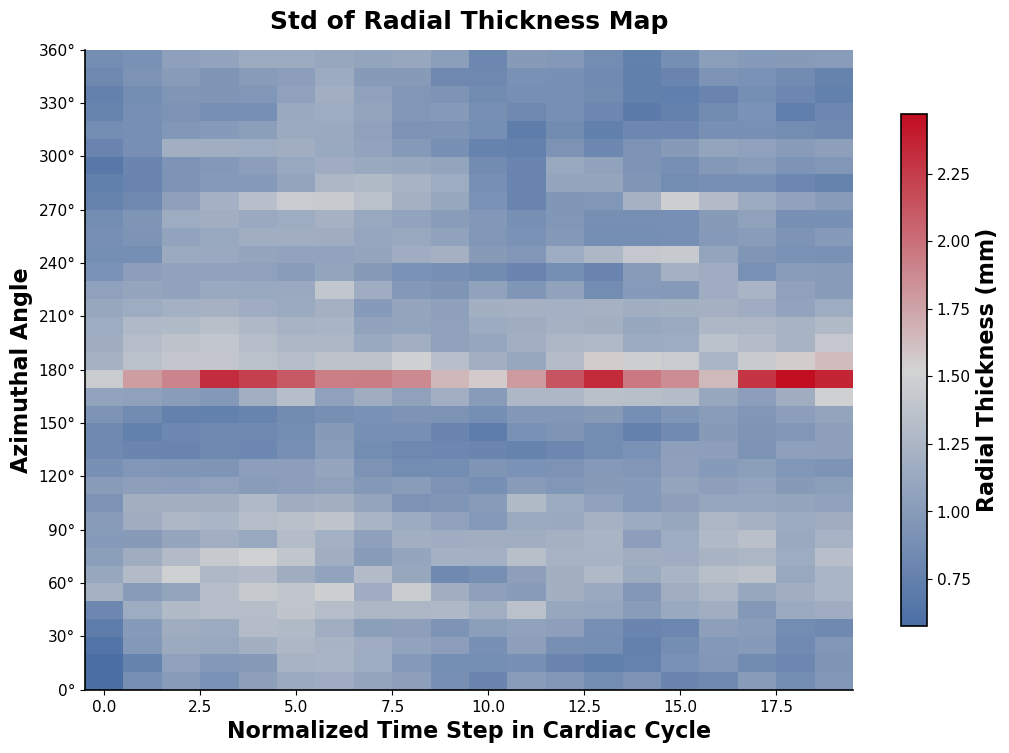

In [42]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Heart_Failure_Infarct_std_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(std_map, mean_bool=False, save_path = save_path)

# Heart Failure with Infarct

In [43]:
#write code to generate the numpy array for all time steps for one data set
all_thickness_maps = {}


for dataset in datasets_failure:
    thickness_maps_o_time = []
    i = 0

    while True:
        try:
            z_coords = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/filtered_z_coords_{i}.npy")
            thickness_map = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/thickness_map_{i}.npy")  # fixed typo: used f-string correctly

            # Average over time to get 1D vector
            z_thickness_map = np.nanmean(thickness_map, axis=0).reshape(-1, 1)
            thickness_maps_o_time.append(z_thickness_map)

            i += 1  # continue to next index

        except FileNotFoundError:
            break  # stop loop when no more files are found
    try:
        # Convert to array (shape: num_subjects × z × 1)
        thickness_maps_o_time = np.concatenate(thickness_maps_o_time, axis=1)  # now shape (z, N)
        # In your loop over datasets
        all_thickness_maps[dataset] = thickness_maps_o_time
    except Exception as e:
            print(f"Error in Dataset {dataset}: {e}")

Error in Dataset SCD0001701: need at least one array to concatenate


In [44]:
#interpolate so that all thickness maps have the same time points along the time axis

# Define target time grid
target_time_len = 20
target_time = np.linspace(0, 1, target_time_len)

interpolated_maps = []

for dataset in datasets_failure:
    try:
        thickness_map = all_thickness_maps[dataset]
        original_time_len = thickness_map.shape[1]
        original_time = np.linspace(0, 1, original_time_len)

        interpolated_map = np.empty((thickness_map.shape[0], target_time_len))

        for z_idx in range(thickness_map.shape[0]):
            row = thickness_map[z_idx, :]

            if np.all(np.isnan(row)):
                interpolated_map[z_idx, :] = np.nan
                continue

            valid_mask = ~np.isnan(row)
            interp = interp1d(original_time[valid_mask], row[valid_mask],
                            kind='linear', bounds_error=False, fill_value=np.nan)
            interpolated_map[z_idx, :] = interp(target_time)

        interpolated_maps.append(interpolated_map)

    except Exception as e:
            print(f"Error in Dataset {dataset}: {e}")


# Stack: shape (20, 20, N)
stacked = np.stack(interpolated_maps, axis=2)

# Compute average and std over the 3rd axis (samples)
mean_map = np.nanmean(stacked, axis=2)
std_map = np.nanstd(stacked, axis=2)

Error in Dataset SCD0001701: 'SCD0001701'


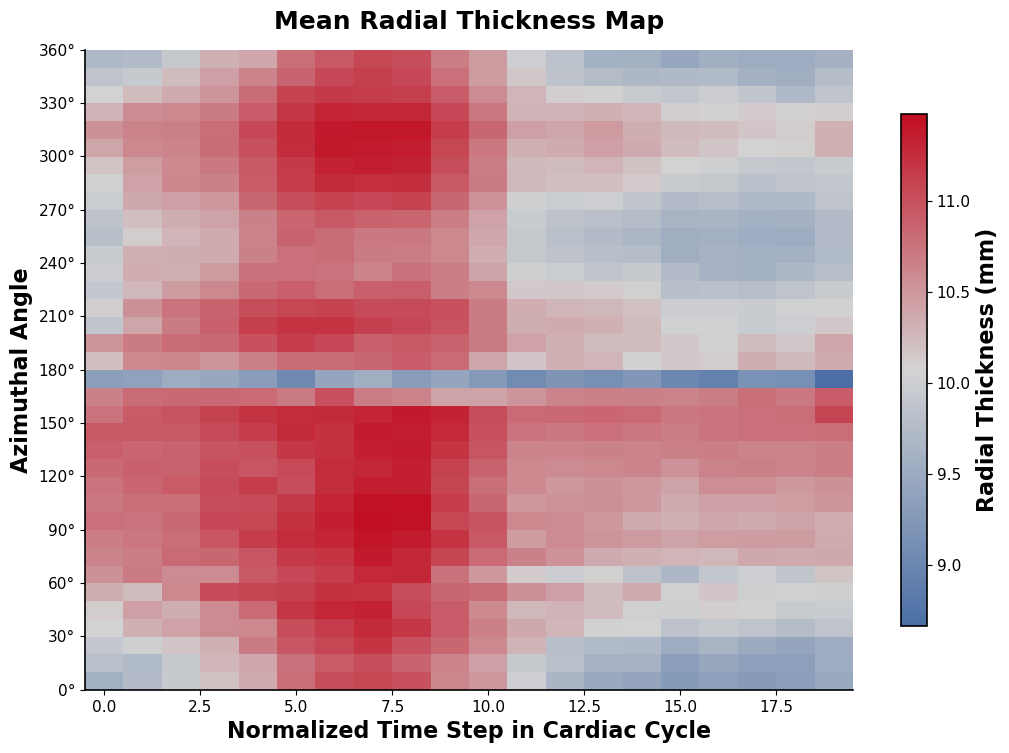

In [45]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Heart_Failure_mean_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(mean_map, mean_bool=True, save_path = save_path)

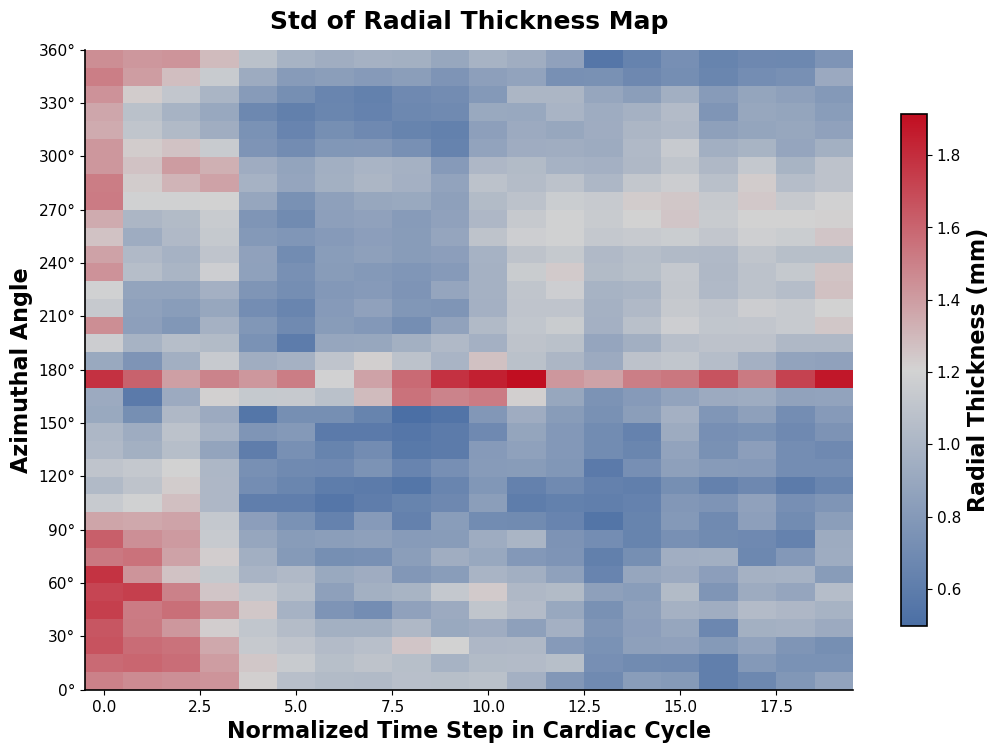

In [46]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Heart_Failure_std_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(std_map, mean_bool=False, save_path = save_path)

# Hypertrophy

In [47]:
#write code to generate the numpy array for all time steps for one data set
all_thickness_maps = {}


for dataset in datasets_Lv:
    thickness_maps_o_time = []
    i = 0

    while True:
        try:
            z_coords = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/filtered_z_coords_{i}.npy")
            thickness_map = np.load(f"/data.lfpn/ibraun/Code/paper_volume_calculation/outputs_patient_data/full_result/{dataset}/mesh_analysis_data/thickness/thickness_map_{i}.npy")  # fixed typo: used f-string correctly

            # Average over time to get 1D vector
            z_thickness_map = np.nanmean(thickness_map, axis=0).reshape(-1, 1)
            thickness_maps_o_time.append(z_thickness_map)

            i += 1  # continue to next index

        except FileNotFoundError:
            break  # stop loop when no more files are found
    try:
        # Convert to array (shape: num_subjects × z × 1)
        thickness_maps_o_time = np.concatenate(thickness_maps_o_time, axis=1)  # now shape (z, N)
        # In your loop over datasets
        all_thickness_maps[dataset] = thickness_maps_o_time
    except Exception as e:
            print(f"Error in Dataset {dataset}: {e}")

Error in Dataset SCD0002601: need at least one array to concatenate
Error in Dataset SCD0002701: need at least one array to concatenate
Error in Dataset SCD0002801: need at least one array to concatenate
Error in Dataset SCD0003101: need at least one array to concatenate
Error in Dataset SCD0003601: need at least one array to concatenate


/tmp/ipykernel_201504/2582333667.py:15: RuntimeWarning: Mean of empty slice
  z_thickness_map = np.nanmean(thickness_map, axis=0).reshape(-1, 1)


In [48]:
#interpolate so that all thickness maps have the same time points along the time axis

# Define target time grid
target_time_len = 20
target_time = np.linspace(0, 1, target_time_len)

interpolated_maps = []

for dataset in datasets_Lv:
    try:
        thickness_map = all_thickness_maps[dataset]
        original_time_len = thickness_map.shape[1]
        original_time = np.linspace(0, 1, original_time_len)

        interpolated_map = np.empty((thickness_map.shape[0], target_time_len))

        for z_idx in range(thickness_map.shape[0]):
            row = thickness_map[z_idx, :]

            if np.all(np.isnan(row)):
                interpolated_map[z_idx, :] = np.nan
                continue

            valid_mask = ~np.isnan(row)
            interp = interp1d(original_time[valid_mask], row[valid_mask],
                            kind='linear', bounds_error=False, fill_value=np.nan)
            interpolated_map[z_idx, :] = interp(target_time)

        interpolated_maps.append(interpolated_map)

    except Exception as e:
            print(f"Error in Dataset {dataset}: {e}")


# Stack: shape (20, 20, N)
stacked = np.stack(interpolated_maps, axis=2)

# Compute average and std over the 3rd axis (samples)
mean_map = np.nanmean(stacked, axis=2)
std_map = np.nanstd(stacked, axis=2)

Error in Dataset SCD0002601: 'SCD0002601'
Error in Dataset SCD0002701: 'SCD0002701'
Error in Dataset SCD0002801: 'SCD0002801'
Error in Dataset SCD0003101: 'SCD0003101'
Error in Dataset SCD0003601: 'SCD0003601'


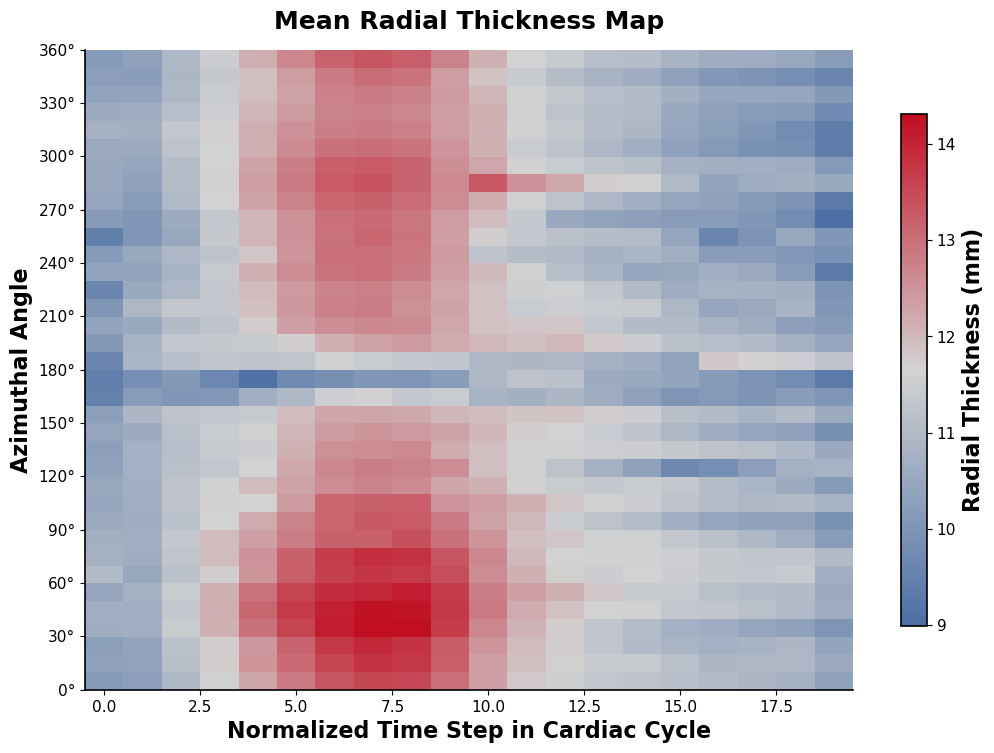

In [49]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Hypertrophy_mean_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(mean_map, mean_bool=True, save_path = save_path)

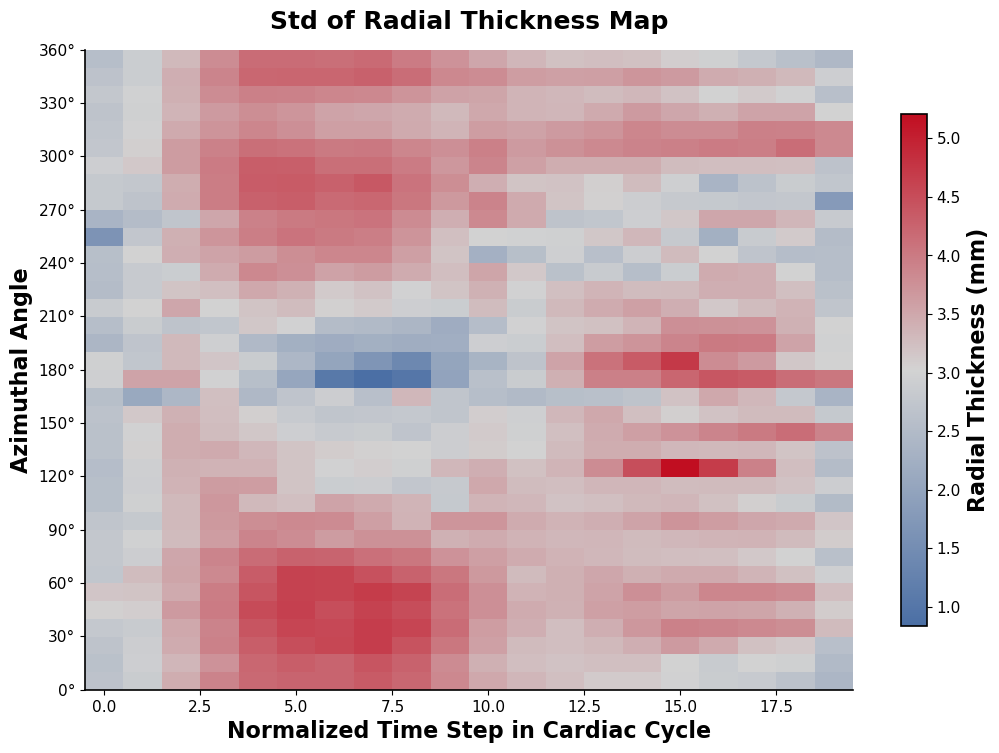

In [50]:
save_path = "/data.lfpn/ibraun/Code/paper_volume_calculation/Plotting/Generated_Plots/Thickness_cardiac_cycle/Averaged_over_Z/Hypertrophy_std_azimutal_thickness.pdf"
plot_thickness_map_sep_color_bars(std_map, mean_bool=False, save_path = save_path)